## Towards Resnet using CIFAR 10
[DL7 Video](https://www.youtube.com/watch?v=H3g26EVADgY&feature=youtu.be&t=1h1m58s)

In [1]:
%pwd
#!ls data/cifar10/

'/home/german/DeepLearning'

The CIFAR-10 dataset consists of 60K 32x32 colour images in 10 classes, with 6K images per class. 
There are 50K training images and 10K test images.<br>
The dataset is divided into 5 training batches and one test batch, each with 10000 images. 
The test batch contains exactly 1000 randomly-selected images from each class. 
The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. 
Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each: airplane,automobile,bird,cat,deer,dog,frog, horse, ship, truck.

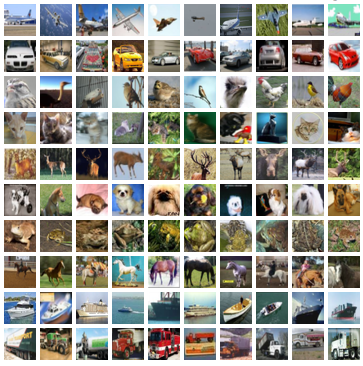

The classes are mutually exclusive, e.g. there is no overlap between automobiles and trucks. 
“Automobile” includes sedans, SUVs, etc.  
“Truck” includes only big trucks. 
Neither includes pickup trucks.

## Prepare Data

### A note on smaller datasets
CIFAR 10 is a small dataset. 
Much more challenging, smaller dataset and much smaller images. 
It’s a great place to start with the CIFAR-10 dataset.

As Ali Rahini said in NIPS 2017, there’s a lack of rigor in DL experiments, 
many people are not doing carefully tuned experiments.
Instead, they throw lots of GPUs and TPUs or lots of data. 
It is important to test many versions of an algorithm on datasets like CIFAR 10 rather than ImageNet. 
Is my algorithm meant to be small vs. large? 
People complain about MNIST (numbers/digits dataset), but to understand different parts of 
an algorithm, MNIST is a great place to start.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Get the CIFAR data via:
```
!wget http://pjreddie.com/media/files/cifar.tgz
!cp cifar.tgz data/CIFAR/
tar -xzvf cifar.tgz 
```

In [3]:
from fastai.conv_learner import *
PATH = "data/CIFAR/cifar/"
OUTPATH=PATH+"cifar10/"
os.makedirs(PATH,exist_ok=True)
os.makedirs(OUTPATH,exist_ok=True)

### Stats 
We need the stats to normalize (as we are trainning a model from scratch). 
The stats are the mean and standard deviation for the classes, for each (RGB) channel.<br>
When we use pre-trained models, we can call `tfms_from_model` which creates the necessary transforms to convert the dataset into a normalized dataset, based on the means and standard deviations of each channel in the original model that was trained in.<br> 
Since we are training a model from scratch, we need to tell it the mean and standard deviation 
of the data to normalize it. 
Below we calculate the mean and the standard deviation for each [R, G, B] channel.

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

trainset = dset.CIFAR10(root='data', train=True, download=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=50_000, shuffle=True)
train = train_loader.__iter__().next()[0]

#print('Mean: {}'.format(np.mean(train.numpy(), axis=(0, 2, 3))))
# Mean: [ 0.49139765  0.48215759  0.44653141]
#print('STD: {}'.format(np.std(train.numpy(), axis=(0, 2, 3))))
# STD: [ 0.24703199  0.24348481  0.26158789]

cifarmeans = np.mean(train.numpy(), axis=(0, 2, 3))
cifarstds = np.std(train.numpy(), axis=(0, 2, 3))
stats = (cifarmeans, cifarstds)
stats

Mean: [0.4914  0.48216 0.44653]
STD: [0.24703 0.24348 0.26159]


(array([0.4914 , 0.48216, 0.44653], dtype=float32),
 array([0.24703, 0.24348, 0.26159], dtype=float32))

## Prepare validation set
### Create sub-folders by class;

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for x in classes:
    os.makedirs(OUTPATH+'train/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'val/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'test/'+x,exist_ok=True)

### Move the files based on the file name

In [7]:
filenames = os.listdir(PATH+'train/')
counts = {x:0 for x in classes}
print(len(filenames))

50000


### Create our Validation and Train sets based on file name

In [8]:
import shutil
valset_size = len(filenames) / 10 * .2
for file_n in filenames:
    for x in classes:
        if x in file_n:
            counts[x] = counts[x] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/'+x+'/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/'+x+'/'+file_n)
        if 'automobile' in file_n:
            counts['car'] = counts['car'] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/car/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/car/'+file_n)

### Make a validation set

In [9]:
filenames = os.listdir(PATH+'test/')
for file_n in filenames:
    shutil.copy(PATH+'test/'+file_n, OUTPATH+'test/'+file_n)

## Set up our ImageClassifierData object

This will create our image generator with the following notes:

- `RandomFlip()`- our basic data augmentation for flipping pictures up and down
- `pad = sz//8` - this will add padding to the edges, (4 pixels in each side) 
and allow us to properly grab the corners of the image
- `stats` - the image status calculated above
- `OUTPATH`, location of CIFAR-10 set

Random flipping and padding over the edge. 
Then we create the ImageClassifier.

tfms — For CIFAR 10 data augmentation, people typically do horizontal flip and black padding around the edge and randomly select 32 by 32 area within the padded image.

In [10]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)  # [RandomFlipXY()], pad=sz//8)
    return ImageClassifierData.from_paths(OUTPATH, val_name='val', tfms=tfms, bs=bs)

In [11]:
bs=256 # because they are small, we can use a larger batch size.

### Look at data

In [12]:
data = get_data(32,4)

In [13]:
x,y=next(iter(data.trn_dl))

In [14]:
type(x)

torch.Tensor

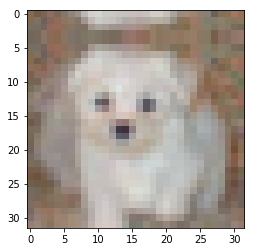

In [15]:
plt.imshow(data.trn_ds.denorm(x)[0]);

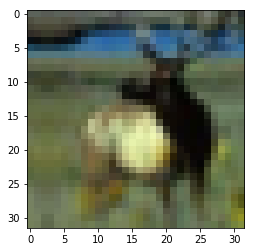

In [16]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model - "Simplenet"

In [17]:
data = get_data(32,bs)

In [18]:
lr=1e-2

### `SimpleNet` 
From [Kerem Turgutlu notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/study/Exploring%20Optimizers.ipynb)

In `__init__` it will make $layers$ number of fully connected linear layers.
- `self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])`

In `forward` :

- `x = x.view(x.size(0), -1)` - flatten the data as it comes in
- `l_x = l(x)` - call the linear layer
- `x = F.relu(l_x)` - apply the ReLU to the layer
- `F.log_softmax(l_x, dim=-1)` so that we can make probabilities for 10 classes

In [19]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

`nn.ModuleList` — whenever we create a list of layers in PyTorch, we must wrap it in `ModuleList` to register these as attributes.

Now we step up one level of API higher, rather than calling `fit`, we create a learn object from a custom model. `ConfLearner.from_model_data` takes standard PyTorch model and model data object.
Make a learner for our general model

In [20]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

Now we step up one level of API higher — rather than calling the `fit` function, we create a `learn` object from a custom model. 
`ConvLearner.from_model_data` takes a standard PyTorch model and model `data` object.

So what is our design?
- 3072 features = (32x32 pixels) x 3 channels
- 40 features going out and going in
- 10 because we have 10 classes we are trying to classify
- 122800 total parameters

In [21]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [22]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', tensor(1.2292e+05))])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', tensor(410))]))])

In [23]:
learn.lr_find()

 77%|███████▋  | 123/160 [00:09<00:02, 12.82it/s, loss=11.3]


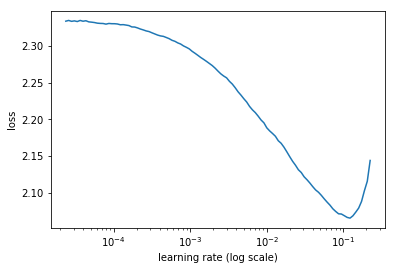

In [24]:
learn.sched.plot()

In [25]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.797553   1.676055   0.407954  
    1      1.690092   1.586699   0.44533                    

CPU times: user 39.3 s, sys: 13.1 s, total: 52.5 s
Wall time: 28.9 s


[1.5866985637336288, 0.4453304096689541]

In [26]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.612468   1.539082   0.461477  
    1      1.602418   1.519851   0.464268                   

CPU times: user 38.9 s, sys: 13.1 s, total: 52.1 s
Wall time: 28.8 s


[1.5198512862950821, 0.46426791575878673]

So with 1 hidden layer, 122K parameters we only got .464 accuracy...  Lets improve it.

## CNN
[DL6 Video](https://youtu.be/H3g26EVADgY?t=1h12m30s)
On our way to ResNet: first convolutional model: (0.56 accuracy)
Fully connected layer - is really doing a dot product. 
Previously 122800 is a weight for every pixel.  
We are not using the parameters efficiently, as every single pixel in the input has a different weight. 
We want to do is a group of 3x3 pixels that have particular patterns to them (i.e. convolution).
Now lets take the same code and replace nn.Linear with `nn.conv2d`.
Every time we want to make the next layer smaller.
In the "old days",  this was done with maxpooling...now we don't use maxpooling, 
but rather use a stride=2 convolution, i.e., move 2 the right, at the end of the row 2-down. 
This also halves the resolution.
The first parameters are number of features in and out.
We will use a filter with a 3x3 kernel. 
When there are multiple filters, the output will have additional dimension.

Instead of telling it what to create, we tell it what we expect.
The penultimate layer, `adaptiveMaxPool` is made to be 1x1, the single largest cell 
and use it as an activation, so we get a 1x1x{number of features} tensor.
So the next step with `.view` it returns a matrix of minibatch x number_of_features.  

In [27]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1) # penultime layer is made into a 1x1 maxpool
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

```
nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
```
- Replace nn.Linear with `nn.Conv2d`
- First two parameters are exactly the same as nn.Linear — 
the number of features coming in, and the number of features coming out 
- `kernel_size=3` is the size of the filter
- `stride=2` will use every other 3 by 3 area which will halve the output resolution in each dimension (i.e. it has the same effect as 2 by 2 max-pooling)

```
self.out = nn.Linear(layers[-1], c)
```
Notice the last parameter c=10, which indicates how many classes we want as output (for the 10 CIFAR categories)

In [28]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

It start with 3 RGB channels, 20, 40, 80 features, then 10 classes to predict.

See how the output shape keeps changing below....
Note the change of the sizes
32 -> 15 -> 7 -> 3 -> 1

`AdaptiveMaxPool2d` - you don’t tell it how bit of a pool that you need, but instead telling it the output size and the pool will calculate what size will be needed. Normal practice is to make a 1x1 max pool as the last layer to ensure that we have the right size.

- `for l in self.layers: x = F.relu(l(x))` - does all the conv layers
- `x = self.pool(x)` - adaptive max pool
- `x = x.view(x.size(0), -1)` - gets rid of training axis 1,1

At the end we need to get 10 classes....
This is called a *Fully Convolutional Network*, where every layer is Convolutional except the last.

Now we have about 1/4 the number of parameters as in the SimpleNet....but much better accuracy.

In [29]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', tensor(28880))])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
 

lr_find below override the last one so it will try more... (?)

In [30]:
learn.lr_find(end_lr=100)

 74%|███████▍  | 119/160 [00:22<00:07,  5.26it/s, loss=1.19e+04]

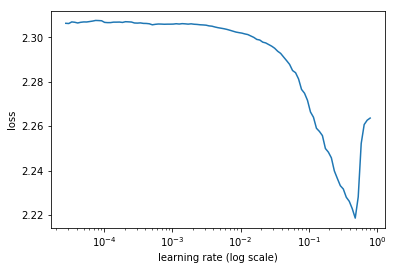

 74%|███████▍  | 119/160 [00:40<00:13,  2.97it/s, loss=1.19e+04]

In [31]:
learn.sched.plot()

The default final learning rate `lr_find` tries is 10. 
If the loss is still getting better at that point, overwrite by specifying `end_lr` .

In [32]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.755271   1.624176   0.40596   
    1      1.57816    1.464302   0.476826                   
CPU times: user 40 s, sys: 13.5 s, total: 53.5 s
Wall time: 29.3 s


[1.4643015278712899, 0.47682647261058275]

In [33]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.398541   1.323398   0.523273  
    1      1.335085   1.245936   0.559055                   
    2      1.259795   1.192678   0.576896                   
    3      1.231777   1.167461   0.587661                   
CPU times: user 1min 20s, sys: 26.3 s, total: 1min 46s
Wall time: 58.4 s


[1.1674609621987675, 0.5876607196608818]

In [34]:
%time learn.fit(1e-1, 1, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.190757   1.121181   0.601116  
CPU times: user 20 s, sys: 6.72 s, total: 26.8 s
Wall time: 14.6 s


[1.121180942179044, 0.6011163160972743]

It flattened out around 60% accuracy, using about 30K parameters (vs Simplenet 46% with 122K parameters).
Time per epoch is about the same, since their architectures are both simple, most time is spent doing memory transfer.

## Refactored
Simplify `forward` function by creating `ConvLayer` (our first custom layer!). 
In PyTorch, layer definition and NN definitions are identical. 
Anytime we have a layer, we can use it as a NN, and viceversa, every NN can be used as a layer. 

Want to have less stuff inside my forward...
And add padding.
grouping things to make life easier.
We will make a custom conv. layer to bundle the conv2d along with a relu. 
We are also adding padding to take in account the corners of the image.

In [35]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

`padding=1` — When we do convolution the image shrinks by 1 pixel on each side. 
So it does not go from 32x32 to 16x16 but to 15x15. 
`padding` adds a border so we can keep the edge pixel information. 
It is not critical for a big image, but when it’s small, down to 4x4, 
we don’t want to throw away a whole piece.

In [37]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

Another difference from the last model is that `nn.AdaptiveMaxPool2d` does not have any state (i.e. no weights). 
So we can just call it as a function `F.adaptive_max_pool2d`.

In [38]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [39]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
 

In [40]:
wd=1e-4

In [41]:
%time learn.fit(1e-1, 2, wds=wd, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.870675   1.729159   0.368584  
    1      1.623363   1.493473   0.465165                   
CPU times: user 40 s, sys: 13.3 s, total: 53.3 s
Wall time: 29.3 s


[1.493473335704026, 0.46516495571468686]

In [42]:
%time learn.fit(1e-1, 2, wds=wd, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.492189   1.395545   0.498854  
    1      1.417148   1.314385   0.523273                   
CPU times: user 40.2 s, sys: 13 s, total: 53.2 s
Wall time: 29.3 s


[1.3143846631157046, 0.5232731983738408]

## BatchNorm
Batch Normalization (0.68 accuracy) <br>
- When we tried to add more layers we had problems training it. 
If we have smaller $\mu$, it takes too long, and if we made larger $\mu$, 
it would become unstable, would go off to NaN. 
It is likely that the weight matrices, on average, 
will cause activations to keep getting smaller and smaller (or bigger and bigger). 
It is important to keep them at reasonable scale. 

- To make it resilient, we use batch normalization, a method that helps train deeper networks.
- Pytorch provides `nn.BatchNorm`. But to learn about it, we write it from scratch.

So we start things off with 0-mean 1-standard deviation by normalizing the input. <br> 
**Normalize every layer, not just the inputs.**
So we need to calculate the mean and std (per channel or per filter) and remove it accordingly...

This additional code will normalize the matrix first by channel and later by filters.
```
if self.training:
   self.means = x_chan.mean(1)[:,None,None]
   self.stds  = x_chan.std (1)[:,None,None]
```

But, there is a conflict with SGD, and it won’t help, as SGD will try to undo it on the next minibatch.
So we create a new multiplier (`self.m`) and new addition (`self.a`) for each channel.
(`m` initialized to 1s, and `a` to 0s).
```
    self.a = nn.Parameter(torch.zeros(nf,1,1))
    self.m = nn.Parameter(torch.ones(nf,1,1))
```
By telling Pytorch that `m` and `a` are `nn.Parameter` they are learned as if they were weights.

Then we can do the multiplication. 
This seems weird because we are multiplying by 1 and adding zero. 
But this will let SGD shift the weights around in the `m` and `a` variables. 
We are normalizing the data, and SGD is moving and shifting it using far fewer variables than previously.
```
return (x-self.means) / self.stds *self.m + self.a
``` 
 This increases resiliency and let’s us increase the learning rate and more learning rates.

In [43]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None] 
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

- Calculate the mean of each channel or each filter and standard deviation of each channel or each filter. 
Then subtract the means and divide by the standard deviations.
- We no longer need to normalize our input because it is normalizing it per channel or for later layers it is normalizing per filter.
- This is not enough since SGD is bloody-minded [01:29:20]. 
If SGD decided that it wants matrix to be bigger/smaller overall, doing `(x=self.means) / self.stds` is not enough because SGD will undo it and try to do it again in the next mini-batch. 
So we add two parameters: `a` — adder (initial value zeros) and `m` — multiplier (initial value ones) for each channel.
- `nn.Parameter` tells PyTorch that it is allowed to learn these as weights.

**Why does this work?** 
If it wants to scale the layer up, it does not have to scale up every single value in the matrix. 
It can just scale up the single trio of numbers `self.m`.
If it wants to shift it all up or down a bit, it does not have to shift the entire weight matrix, 
they can just shift the trio of numbers `self.a`. 

**Intuition**: We are normalizing the data.
And then we can shift it and scale it using far fewer parameters (`a` and `m`) than would have been necessary if it were to actually shift and scale the entire set of convolutional filters. 
In practice, it allows to increase the learning rates, 
increase resilience of training, and add more layers and still train effectively.

batch norm also regularizes, so we can often decrease or remove dropout or weight decay. 
The reason why is each mini-batch is going to have a different mean and a different standard deviation 
to the previous mini-batch. 
So they keep changing the meaning of the filters in a subtle way acting as a noise 
(i.e. regularization).
In real version, it does not use this batch’s mean and standard deviation,
but rather takes an exponentially weighted moving average standard deviation and mean.

- `if self.training` — when going through the validation set, we do **not** want to change the meaning of the model. 
There are some types of layers that are sensitive to what the "mode" of the network 
is whether it is in training mode or evaluation/test mode. 

In PyTorch, there are 2 such layers: `dropout` and `batchnorm`. 
`nn.Dropout` already does the check.
[01:37:01] 
The key difference in fast.ai is that the means and standard deviations get updated in training mode.
Other libraries, do it at training, regardless of whether that layer is set to trainable or not. 
With a pre-trained network, that is a terrible idea. 
In a pre-trained network for specific values of those means and standard deviations in batch norm, 
if you change them, it changes the meaning of those pre-trained layers. 

In fast.ai, always by default, it will not touch those means and standard deviations if the layer is frozen. 
When we un-freeze it, it will start updating them, **unless** we set `learn.bn_freeze=True`. 
In practice, this works better for pre-trained models, particularly if we work 
with data that is quite similar to what the pre-trained model was trained with.

Where to put batchnorm? <br>
The original paper did not put it in the best spot, an oversight that later caused problems.
If we can, always use batchnorm on every layer. 
Don’t stop normalizing the data, so that people using the data will know how you normalized your data. 
Other libraries might not deal with batchnorm for pre-trained models correctly, 
so when people start re-training, it might cause problems.

**Two changes**
- Added the BnLayer.
- Added a ‘rich’ Conv2d layer up front. 
Instead of a 3x3, we are doing a 5x5 / 7x7 convolution with a large number of filters.

In [44]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

- Rest of the code is similar — Using `BnLayer` instead of `ConvLayer`.
- A single convolutional layer was added at the start (trying to get closer to modern approaches). 
    - It has a bigger kernel size and a stride of 1. 
    - We want the first layer to have a richer input. 
    - It does convolution using the 5x5 area which allows it find more interesting, richer features.
    - Then spit out bigger output (in this case, it’s 10x5x5 filters). 
    - Typically it is 5x5 or 7x7, or even 11x11 convolution, with many filters coming out (e.g. 32 filters).
- Since padding = kernel_size — 1 / 2 and stride=1 , the input size is the same as the output size — just more filters.
- It is a good way of trying to create a richer starting point.

In [45]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [46]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7200))])),
             ('BnLayer-5',
   

In [47]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.511157   1.343831   0.511113  
    1      1.317589   1.225683   0.558457                   
CPU times: user 42.7 s, sys: 13.6 s, total: 56.3 s
Wall time: 30.2 s


[1.2256832145259184, 0.5584570916185205]

In [48]:
%time VLA = learn.fit(1e-1, 4, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.202518   1.032449   0.631616  
    1      1.108954   0.980456   0.65444                    
    2      1.046695   0.930649   0.6667                     
    3      0.99786    0.876695   0.68773                     
CPU times: user 1min 24s, sys: 27.6 s, total: 1min 52s
Wall time: 1min


So we now reached {{VLA[0]}} for Validation loss and {{VLA[1]}} for accuracy

## Deep BatchNorm
Let’s make it an even deeper model. 
But we have to be mindful of the image size. 
If we keep reducing the image size, it will eventually be too small.

So each of the stride 2 layers (layers) we also add a stride=1 layer (`layers2` below) which doesn’t change the size. 
Then in forward it does zip of the layers, and then does them consequitevely.
So, now the network is twice as deep, but have the same image size (2x2) at the end.
Now this should be able to help ... but... it does not... :( 

In [49]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [50]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [51]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.548633   1.380522   0.49397   
    1      1.332202   1.21093    0.565534                   
CPU times: user 46.3 s, sys: 14.4 s, total: 1min
Wall time: 31.5 s


[1.21092993412514, 0.5655337385970646]

In [52]:
%time learn.fit(1e-2, 2, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.152171   1.055567   0.621449  
    1      1.10068    1.029303   0.633808                   
CPU times: user 46.3 s, sys: 14.5 s, total: 1min
Wall time: 31.5 s


[1.0293030076127674, 0.6338084321144177]

The accuracy remained the same as before. 
This is now 12 layers deep, and it is too deep even for batchnorm. 
It is possible to train 12 layer deep convnet but it starts to get difficult. 
And it does not seem to be helping much if at all.

So we move to Resnet...

## Residual Network (Resnet)
ResNet block: we are adding the original signal along with the convolution of the input:
```
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)
```    
 $y = x + f(x)$   (Predictions equal input + function of input.)
 $f(x) = y - x$   (shuffled, tries to fit a function to the difference)

Where y is the prediction of the next layer, and x is the prediction of the previous layer. 
The difference is actually the residual (residual = y-x). 
This is basically saying: find some weights to predict the error. 
We are continuously trying to predict the residual error, layer by layer.

This is similar to the idea of **boosting** from machine learning.
It helps a lot!

`return x + super().forward(x)`

$y = x + f(x)$

Where x is prediction from the previous layer, y is prediction from the current layer.
Shuffle around the formula and we get:

$f(x) = y − x$

The difference $y − x$ is residual. 
The residual is the error in terms of what we have calculated so far. 
Find a set of convolutional weights that attempts to fill in the amount we were off by. 
We have an input, and we have a function which tries to predict the error (i.e. how much we are off by). 
Then we add a prediction of how much we were wrong by to the input, then add another prediction of how much we were wrong by that time, and repeat that layer after layer — zooming into the correct answer. 
This is based on a theory called **boosting**.

The full ResNet does 2 convolutions before it gets added back to the original input (we did just one here).
In every block $x = l3(l2(l(x)))$, 
one of the layers is not a ResnetLayer but a standard convolution with stride=2 — this is called a “bottleneck layer”. ResNet does not convolutional layer but a different form of bottleneck block which we will cover in Part 2.

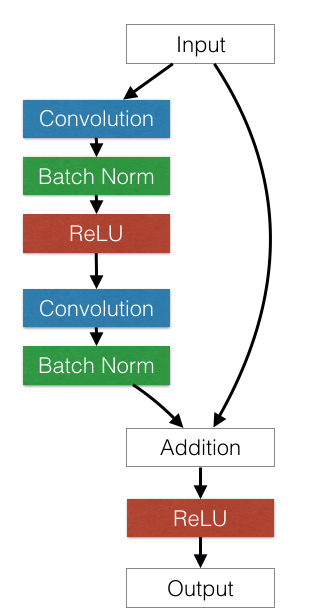

In [55]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

`ResnetLayer` inherits from BnLayer and overrides forward.
Then add bunch of layers and make it 3 times deeper, 
and it still trains beautifully just because of `x + super().forward(x)`.

Note that we have added 2 ResNet layers and also note we have a function of a function of a function:

$x = l3(l2(l(x)))$

In [56]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [57]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [58]:
wd=1e-5

In [60]:
%time learn.fit(1e-2, 2, wds=wd, cycle_len=1,use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.586329   1.384949   0.492874  
    1      1.378814   1.247962   0.553573                   
CPU times: user 49.2 s, sys: 14.6 s, total: 1min 3s
Wall time: 35.3 s


[1.2479618117992988, 0.5535732084478847]

In [61]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                   
    0      1.260152   1.153135   0.587661  
    1      1.170649   1.079153   0.620253                   
    2      1.103016   0.999169   0.645869                   
    3      1.033766   0.960243   0.660221                   
    4      0.969039   0.913344   0.676468                    
    5      0.940869   0.877821   0.690322                    
    6      0.898686   0.849312   0.699193                    
CPU times: user 2min 51s, sys: 51.4 s, total: 3min 42s
Wall time: 2min 2s


[0.8493123315129907, 0.6991926641487046]

In [63]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                    
    0      0.840736   0.840646   0.698993  
    1      0.855745   0.834986   0.703479                    
    2      0.805318   0.79743    0.720622                    
    3      0.715203   0.732687   0.73926                     
    4      0.712357   0.763116   0.733081                    
    5      0.751546   0.776224   0.728596                    
    6      0.7026     0.744999   0.739659                    
    7      0.629579   0.674931   0.764278                    
    8      0.622614   0.711341   0.750025                    
    9      0.665547   0.711198   0.754012                    
    10     0.635436   0.669354   0.762484                    
    11     0.554563   0.636535   0.777833                    
    12     0.549817   0.668705   0.769959                    
    13     0.603982   0.688999   0.762284                    
    14     0.57696    0.6581     0.776936                    
    15     0.507046   0.62

[0.5704358780783884, 0.8076348052856086]

## Resnet 2
Most of these ResNet blocks have 2 convolutions. We call these skip connections.
Here, we increased the size of features and added dropout.


In [ ]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [ ]:
wd=1e-6

In [64]:
%time learn.fit(1e-2, 2, wds=wd, cycle_len=1, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                    
    0      0.382165   0.599259   0.802352  
    1      0.375289   0.604057   0.802253                    
CPU times: user 48.8 s, sys: 14.6 s, total: 1min 3s
Wall time: 35 s


[0.6040571217824227, 0.8022525664294549]

In [65]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                    
    0      0.365552   0.591129   0.808731  
    1      0.359569   0.602688   0.807435                    
    2      0.350689   0.588748   0.80614                     
    3      0.34896    0.588307   0.809628                    
    4      0.337513   0.604859   0.809529                    
    5      0.334967   0.611863   0.808432                    
    6      0.328519   0.61425    0.805841                    
CPU times: user 2min 52s, sys: 51.4 s, total: 3min 43s
Wall time: 2min 3s


[0.6142499614148652, 0.8058407257480825]

In [66]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd, use_clr_beta=(100, 1, 0.9, 0.8))

epoch      trn_loss   val_loss   accuracy                    
    0      0.29536    0.620203   0.805641  
    1      0.345128   0.649077   0.799362                    
    2      0.331859   0.655519   0.798166                    
    3      0.265533   0.581349   0.81521                     
    4      0.260676   0.606395   0.811921                    
    5      0.325811   0.651524   0.799262                    
    6      0.311081   0.601454   0.814113                    
    7      0.252041   0.583087   0.821788                    
    8      0.250884   0.610623   0.817602                    
    9      0.306649   0.67866    0.798565                    
    10     0.290112   0.6006     0.817403                    
    11     0.238791   0.588202   0.822286                    
    12     0.225748   0.608927   0.820193                    
    13     0.282328   0.659488   0.801156                    
    14     0.281116   0.630264   0.814711                    
    15     0.220159   0.59

[0.6362080798429339, 0.8179009269886213]

In [67]:
learn.save('tmp3')

In [68]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [69]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.4857810341691578, 0.8417223163560251)

85% was a state-of-the-art back in 2012 or 2013 for CIFAR 10.<br> 
Nowadays, it is up to 97% so there is a room for improvement but all based on these techniques:
- Better approaches to data augmentation
- Better approaches to regularization
- Some tweaks on ResNet

Question [02:01:07]: 
Can we apply “training on the residual” approach for non-image problem? 
Yes! But it has been ignored everywhere else. 
In NLP, “transformer architecture” recently appeared, and is the state of the art for translation, 
and it has a simple ResNet structure in it. 
This general approach is called “skip connection” (i.e. the idea of skipping over a layer) and appears a lot in computer vision.
But nobody else seems to use it even through there is nothing CV specific about it. Good opportunity!

## End

### TODO: Could we make some blocks simpler using a sequential block like this?
```
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))
```